In [93]:
import os
from dotenv import load_dotenv
load_dotenv()

# importing comet variables stored in .env file
comet_api_key =  os.getenv("COMET_API_KEY")
comet_project_name = os.getenv("COMET_PROJECT_NAME")
comet_workspace_name = os.getenv("COMET_WORKSPACE_NAME")
# print(api_key)
# print(project_name)
# print(workspace_name)

In [1]:
# Integrating comet to track results
from comet_ml import Experiment
experiment = Experiment(
  api_key=comet_api_key,
  project_name=comet_project_name,
  workspace=comet_workspace_name,
  auto_metric_logging=True,
  auto_param_logging=True,
  auto_histogram_weight_logging=True,
  auto_histogram_gradient_logging=True,
  auto_histogram_activation_logging=True,
  auto_histogram_epoch_rate=True,
  log_code=True
)

# setting the experiment name
experiment.set_name("fine_tune_vgg16_v1")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.com https://www.comet.com/nikhil527/image-emotion-classifier/73bb0ed9f875407e8f2001ddc378146d



In [2]:
# Importing the packages required for the project
import keras
import itertools
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping


In [3]:
import sys 
import os

# Adding the parent directory to the sys.path to access helper_functions
parent_directory = os.path.dirname(os.getcwd())

# Adding our parent directory to the list of paths that python searches for modules
sys.path.append(parent_directory) 

from helper_functions import *

In [4]:
# performing some preprocessing and data augmentation techniques to help our
# model generalize better

# rotation_range, width_shift_range, height_shift_range, zoom_range: 
# These parameters will randomly rotate, shift, and zoom images during training 
# to increase variations in our dataset

# horizontal_flip -> This will randomly flip images. 
# All these techniques will help us in generating new data to help the 
# model generalize better on real-world scenarios
training_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

validation_datagen  = ImageDataGenerator(rescale = 1./255)

testing_datagen  = ImageDataGenerator(rescale = 1./255)

training_dataset  = training_datagen.flow_from_directory(directory = r"c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/train/",
                                                   target_size = (48, 48),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

validation_dataset = validation_datagen.flow_from_directory(directory = r"c:/users/saini/onedrive/documents/masters/first semester/machine learning/datasets/fer2013/test/",
                                                  target_size = (48, 48),
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = 64)

testing_dataset = testing_datagen.flow_from_directory(directory = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\CK+\CK+48",
                                                  target_size = (48, 48),
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = 64)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 981 images belonging to 7 classes.


In [5]:
# getting the labels for our training dataset
class_labels = training_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
# emotion_data_count = {}
# for images, labels in training_dataset:
#     for index in range(len(labels)):
#         emotion = np.argmax(labels[index])
#         if(emotion in emotion_data_count):
#             emotion_data_count[emotion] += 1
#         else:
#             emotion_data_count[emotion] = 1
# print(emotion_data_count)

file_path = r"C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\FER2013\train"
# os.listdir(file_path)
emotion_data_count = {}
for folder_name in os.listdir(file_path):
    if(folder_name == 'labels.csv'):
        continue
    folder = f"{file_path}\{folder_name}"
    emotion_data_count[f"{folder_name}"] = len(os.listdir(folder))
print(emotion_data_count)            

{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


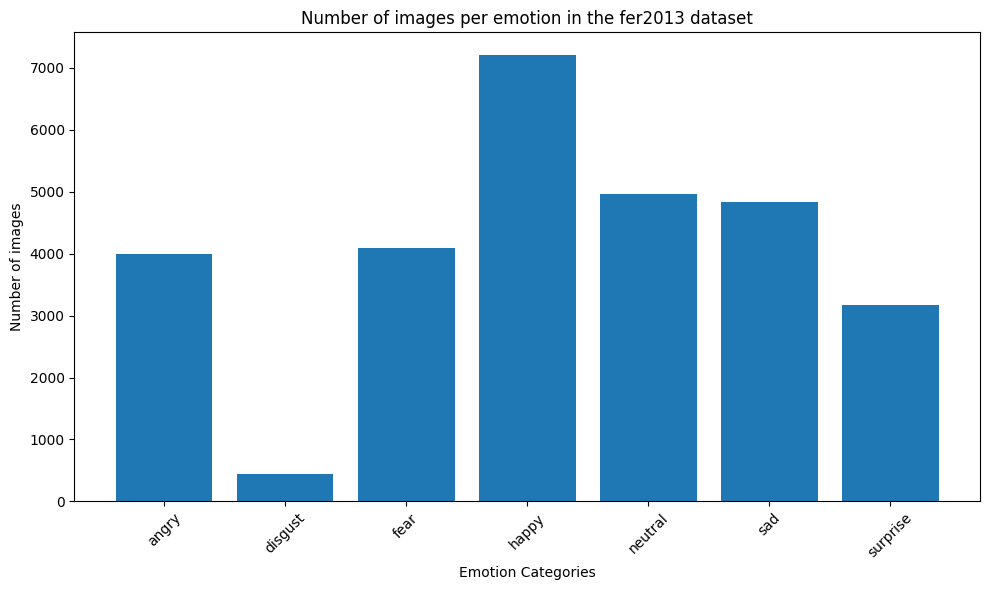

In [7]:
# Plotting the graph to check the number of images in each category
emotion_categories = list(emotion_data_count.keys())
emotion_categories_count = list(emotion_data_count.values())

plt.figure(figsize=(10,6))
plt.bar(emotion_categories, list(emotion_data_count.values()))
plt.xlabel("Emotion Categories")
plt.ylabel("Number of images")
plt.title("Number of images per emotion in the fer2013 dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
images, labels = next(training_dataset)

Text(0.5, 1.0, 'happy')

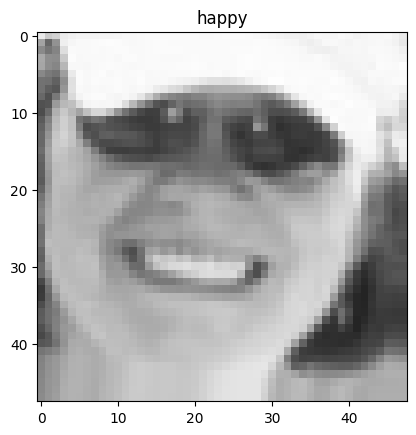

In [9]:
# predicting the label for images
def compute_label_name(label_array, class_indexes):
    class_index = np.argmax(label_array)
    class_name = list(class_indexes.keys())[class_index]
    return class_name
plt.imshow(images[0])
plt.title(compute_label_name(labels[0], class_labels))

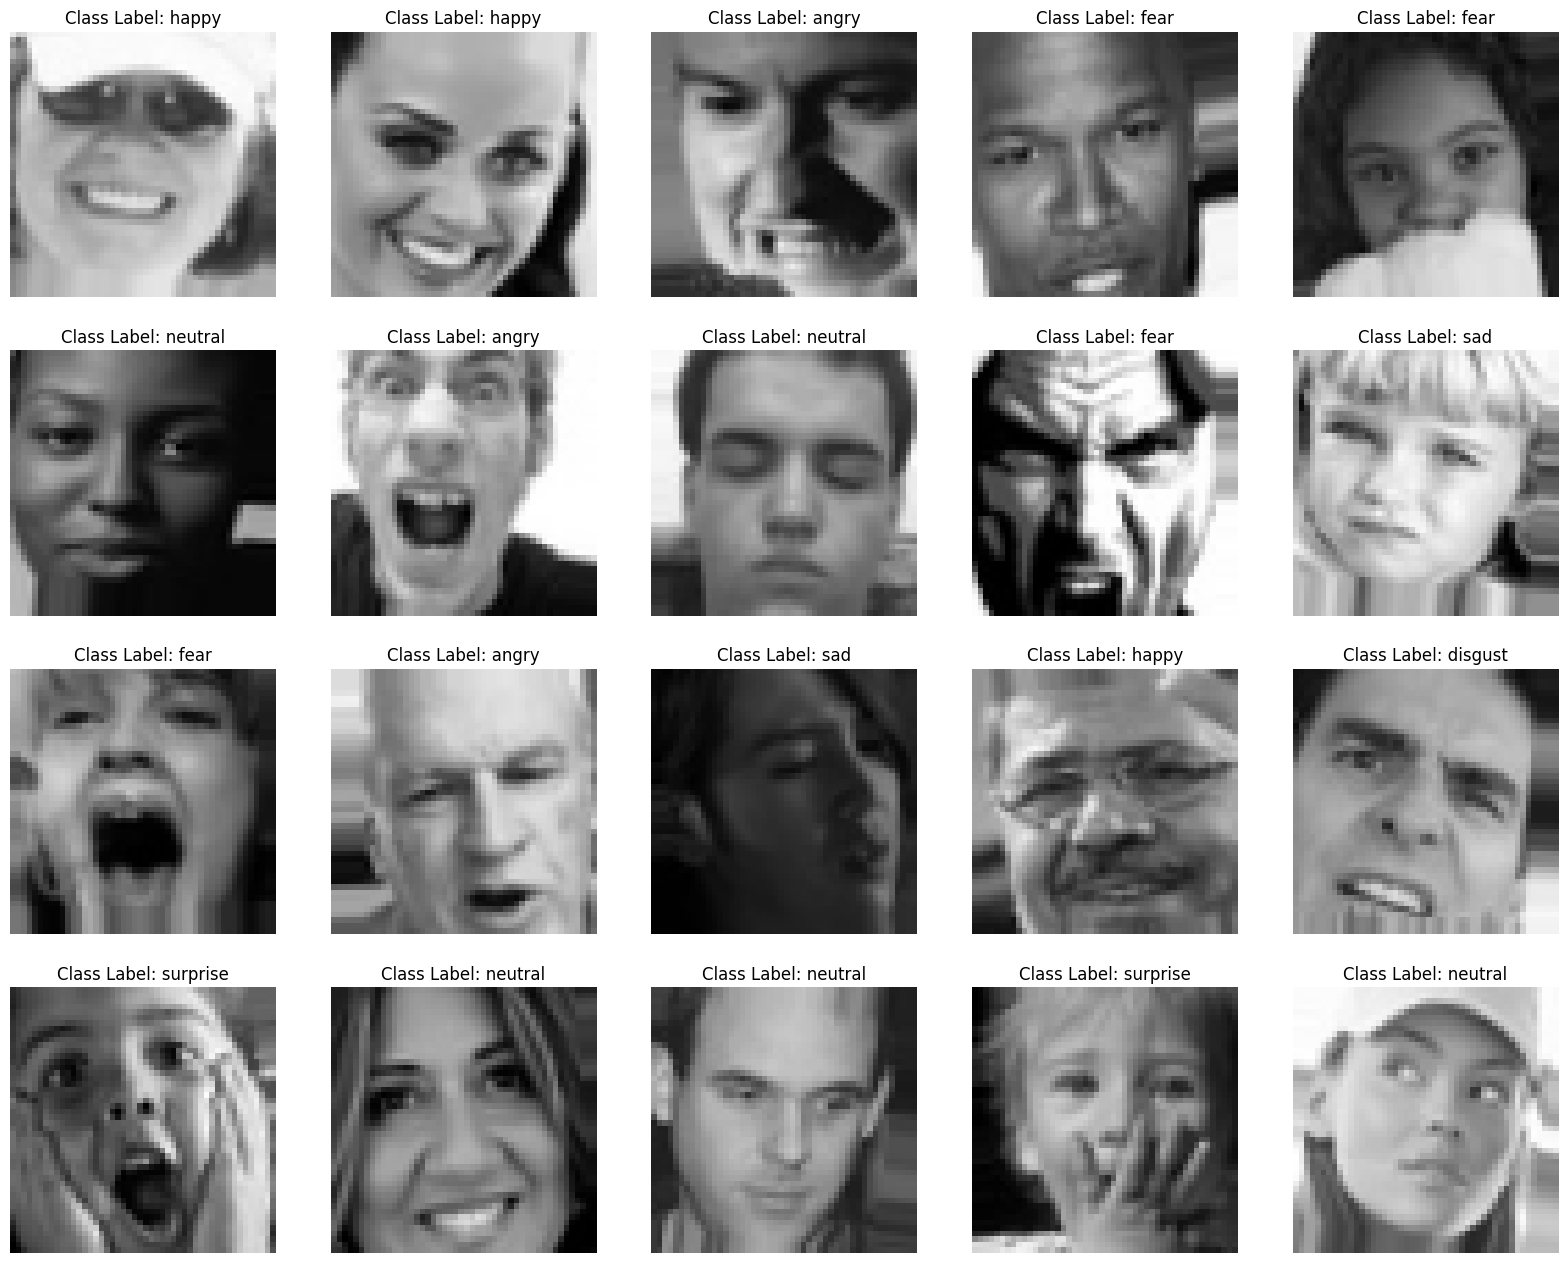

In [10]:
# Plotting more data 
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    input_label = compute_label_name(labels[i], class_labels)
    title = f"Class Label: {input_label}"
    plt.title(title)

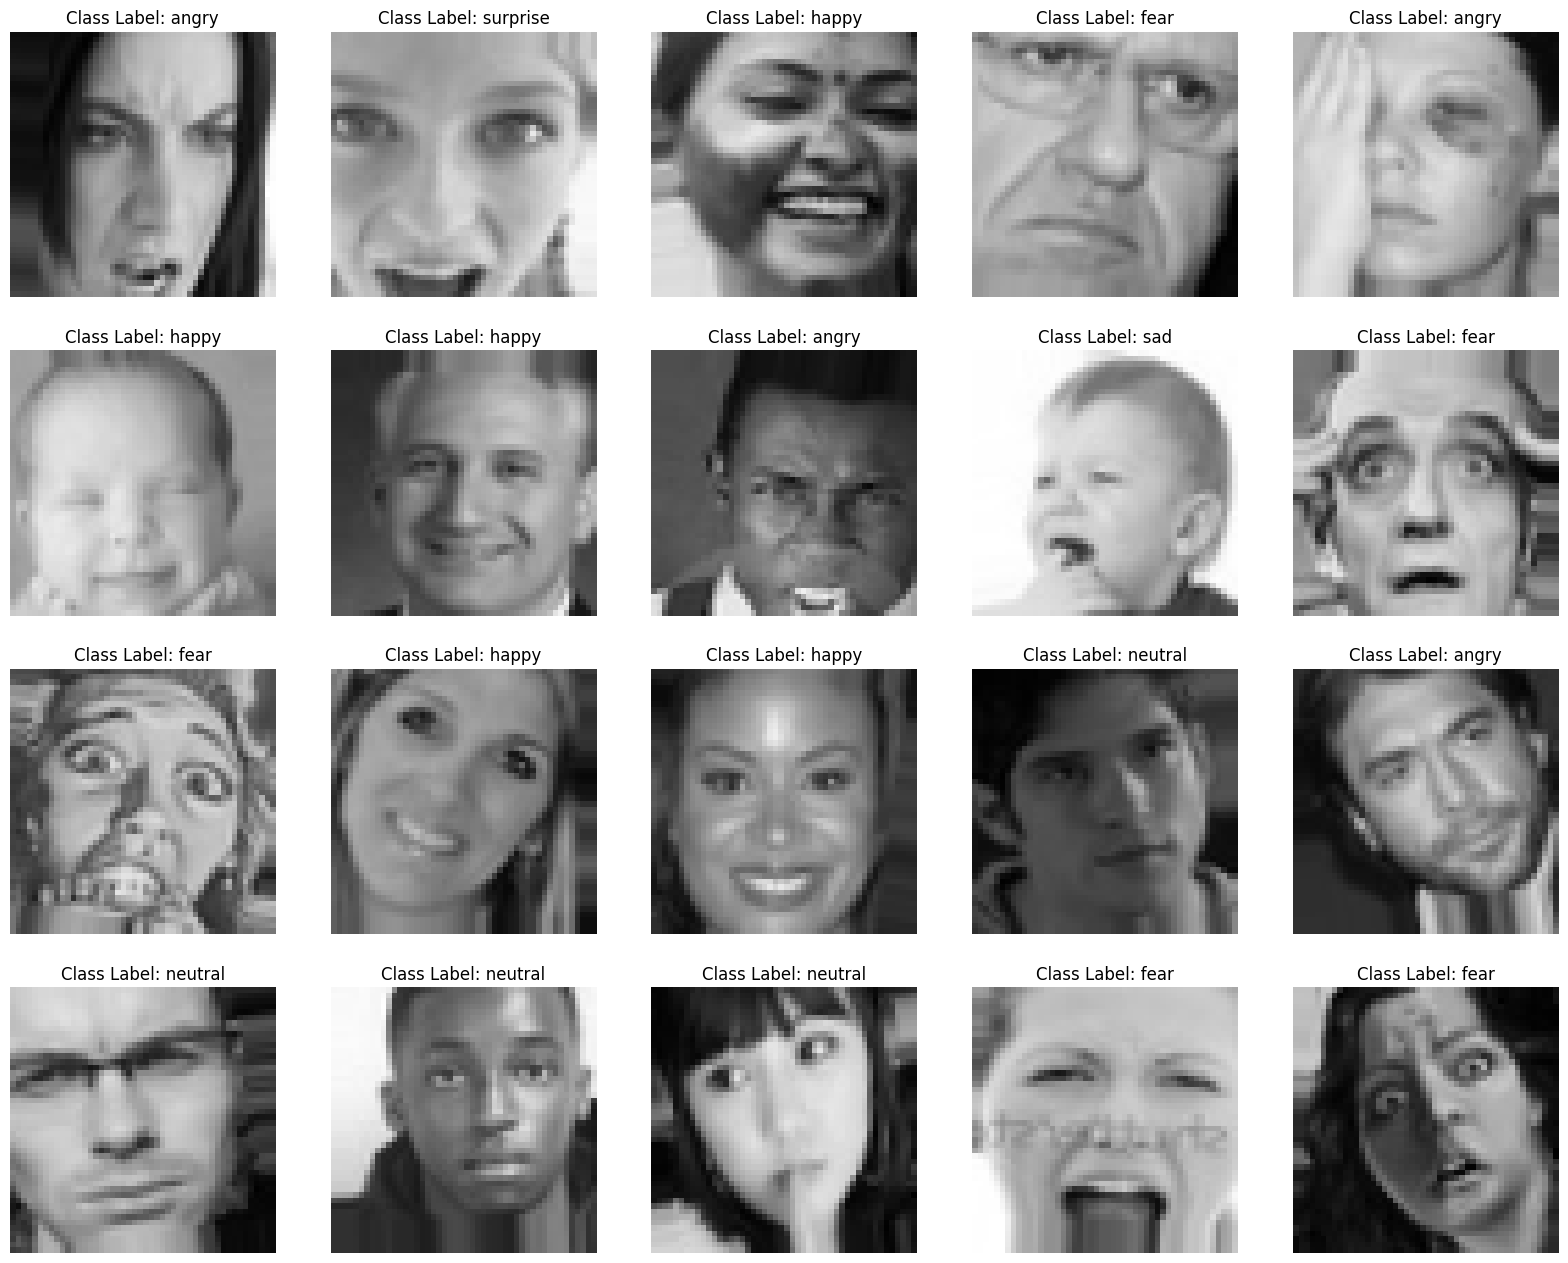

In [11]:
# Plotting some more data points
plt.figure(figsize=(20, 20))
j = 1
for i in range(21, 41):
    plt.subplot(5,5,j)
    j = j + 1
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    input_label = compute_label_name(labels[i], class_labels)
    title = f"Class Label: {input_label}"
    plt.title(title)

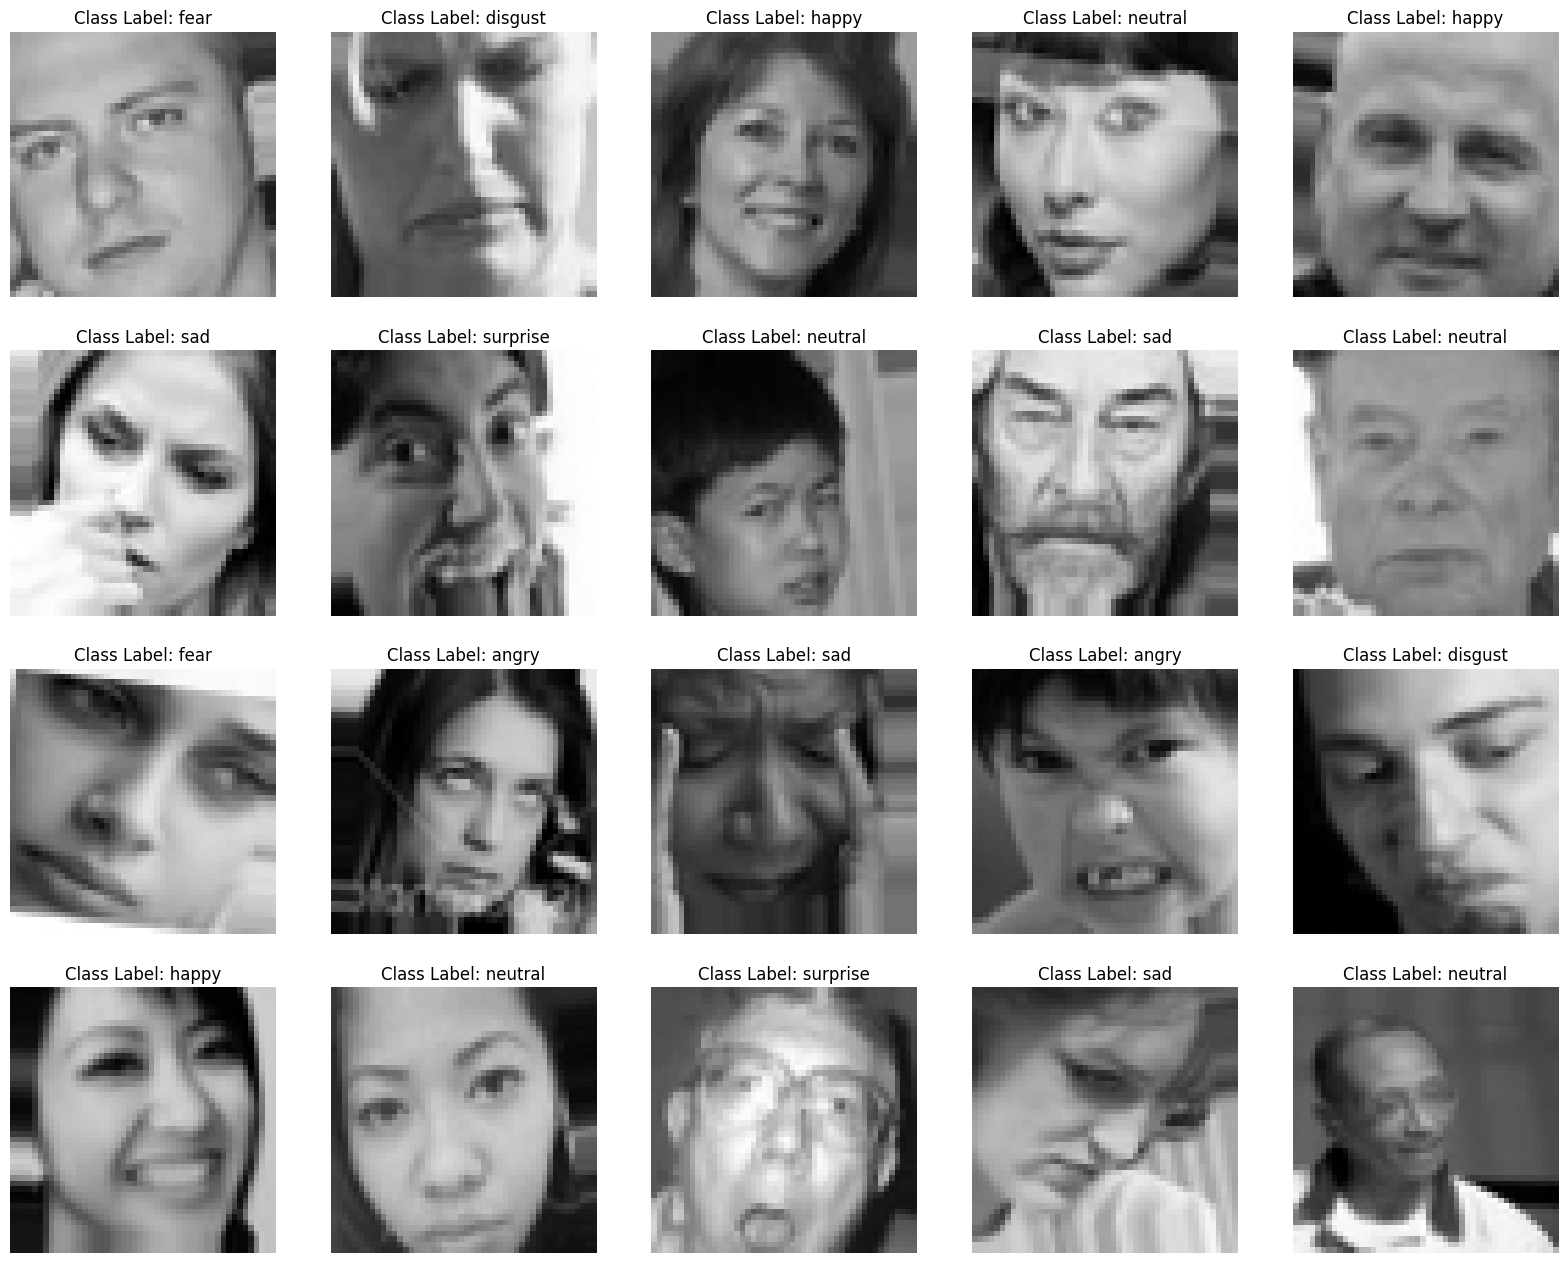

In [12]:
# Plotting some more data points
plt.figure(figsize=(20, 20))
j = 1
for i in range(41, 61):
    plt.subplot(5,5,j)
    j = j + 1
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    input_label = compute_label_name(labels[i], class_labels)
    title = f"Class Label: {input_label}"
    plt.title(title)

In [13]:
# Setting our base model as vgg16 with pretrained weights from imagenet
base_model = tf.keras.applications.VGG16(input_shape= (48,48, 3),include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [14]:
# Freezing the first 11 layers of the base model
for layer in base_model.layers[:11]:
    layer.trainable=False

In [15]:
# Defining the architecture of our model

# creates a sequential model to stack our custom layers
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))  # Added as a regularization technique to make the model more robust to slight variations and noise in input data
model.add(GlobalAveragePooling2D()) # performs spatial average pooling on the previous layer's feature maps, reducing the number of parameters and the computational cost and risk of overfitting

model.add(Flatten()) # converts the pooled feature maps into a single vector. It helps transition 2D feature maps to a 1D vector for the fully connected layers that follow
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001))) # First Fully connected layer with 256 neurons, Relu activations, and L2 regularization with a penalty coefficient of 0.001 on both the kernel and bias weights to prevent overfitting
model.add(BatchNormalization()) #To stabilize the training process
model.add(Dropout(0.5)) # randomly drops out 50% of the neurons in the previous layer during training, preventing individual neurons from becoming reliant on each other and improving generalization

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001))) # Second Fully Connected layer has 128 neurons, Relu activation, and uses L2 regularization similar to the first dense layer
# The second Fully connected layer further learns and refines the features for classification
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax")) # gives the probability distribution over 7 classes.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [16]:
# hyperparams = {
#     "batch_size": 64,
#     "epochs": 30,
#     "learning_rate": 0.001,
#     "patience": 6,

# }

# experiment.log_parameters(hyperparams)

In [17]:
# we are setting the metrics that need to be monitored during our models training
monitor_metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy',metrics=monitor_metrics)

In [18]:
# class_weights ->  This is a dictionary with each class ID mapped to
# a weight. The weights are calculated based on the frequency of each class. 
# our idea here is to give more weight to less frequent classes so that our 
# model does not become biased towards more frequent classes.

counter = Counter(training_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  


# This callback helps us in reducing learning rate when a metric has stopped improving
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 6,verbose = 1,factor = 0.50, min_lr = 1e-10)
# saves the best model after each epoch.
mcp = ModelCheckpoint('vgg16_v1.h5')

# Stops training the model if validation loss doesnt improve over 6 epochs
es = EarlyStopping(verbose=1, patience=6)

results=model.fit(training_dataset,
                  validation_data=validation_dataset,
                  epochs = 30,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations


Epoch 1/30
449/449 [==============================] - 121s 247ms/step - loss: 5.3917 - accuracy: 0.8157 - precision: 0.1994 - recall: 0.0961 - auc: 0.5504 - f1_score: 0.1295 - val_loss: 3.5746 - val_accuracy: 0.8111 - val_precision: 0.3163 - val_recall: 0.2772 - val_auc: 0.6451 - val_f1_score: 0.2941 - lr: 1.0000e-04
Epoch 2/30
449/449 [==============================] - 120s 265ms/step - loss: 4.5942 - accuracy: 0.8355 - precision: 0.3300 - recall: 0.1469 - auc: 0.6335 - f1_score: 0.2027 - val_loss: 3.8490 - val_accuracy: 0.7827 - val_precision: 0.2373 - val_recall: 0.2354 - val_auc: 0.6500 - val_f1_score: 0.2353 - lr: 1.0000e-04
Epoch 3/30
449/449 [==============================] - 128s 283ms/step - loss: 4.0513 - accuracy: 0.8457 - precision: 0.4096 - recall: 0.1808 - auc: 0.6845 - f1_score: 0.2504 - val_loss: 3.0938 - val_accuracy: 0.8258 - val_precision: 0.2851 - val_recall: 0.1456 - val_auc: 0.5994 - val_f1_score: 0.1915 - lr: 1.0000e-04
Epoch 4/30
449/449 [=======================

In [21]:
results.history

{'loss': [5.391733169555664,
  4.594221115112305,
  4.051262855529785,
  3.7984814643859863,
  3.534864664077759,
  3.330660581588745,
  3.1566152572631836,
  2.98268461227417,
  2.872694253921509,
  2.7620849609375,
  2.759755849838257,
  2.648021936416626,
  2.5085482597351074,
  2.4436419010162354,
  2.3507730960845947,
  2.277672052383423,
  2.2416367530822754,
  2.1503541469573975,
  2.1042256355285645,
  2.0378077030181885,
  1.9888465404510498,
  1.9645395278930664,
  1.9017996788024902,
  1.8571972846984863,
  1.7663772106170654,
  1.733359932899475,
  1.7022778987884521,
  1.649214267730713,
  1.5824992656707764,
  1.5416240692138672],
 'accuracy': [0.815737247467041,
  0.835521936416626,
  0.845747709274292,
  0.8536248207092285,
  0.859755277633667,
  0.8645721077919006,
  0.8678562641143799,
  0.8729168772697449,
  0.8753103613853455,
  0.8773057460784912,
  0.8773654699325562,
  0.8792215585708618,
  0.8833417296409607,
  0.8856406211853027,
  0.887427031993866,
  0.889586

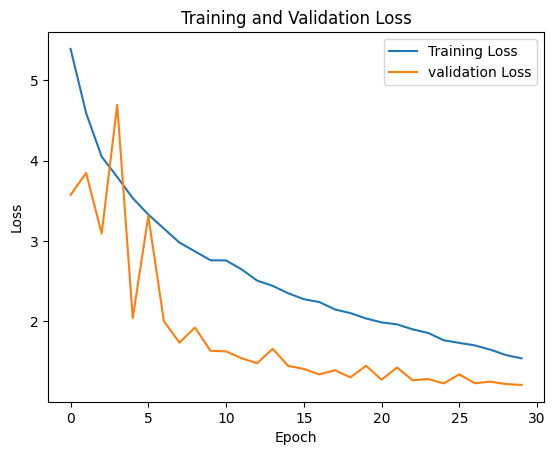

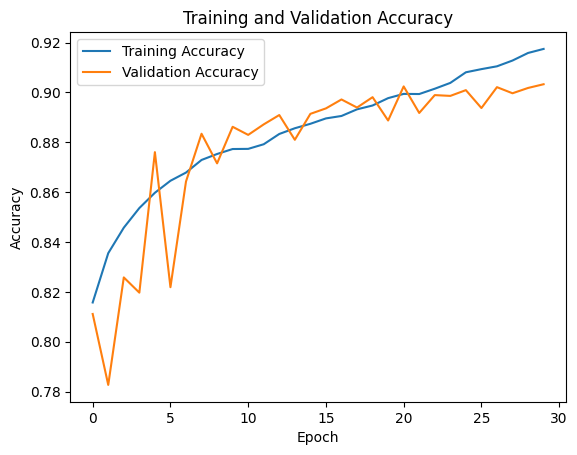

In [22]:
# Plotting the graph for training, validation accuracies and losses
plot_graph(results)

In [23]:
# Stopping the comet ml from tracking results
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nikhil527/image-emotion-classifier/73bb0ed9f875407e8f2001ddc378146d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [30]                  : (0.815737247467041, 0.9174624085426331)
COMET INFO:     auc [30]                       : (0.5503717064857483, 0.936957836151123)
COMET INFO:     batch_accuracy [1350]          : (0.8044496774673462, 0.9330357313156128)
COMET INFO:     batch_auc [1350]               : (0.4495442807674408, 0.9567058086395264)
COMET INFO:     batch_f1_score [1350]          : (0.08510633558034897, 0.7321428060531616)
COMET INFO:     batch_loss [1350]              : (1.3502533435821533, 6.09914

COMET INFO:     validate_batch_auc [360]       : (0.5249696373939514, 0.9590657949447632)
COMET INFO:     validate_batch_f1_score [360]  : (0.13725484907627106, 0.714285671710968)
COMET INFO:     validate_batch_loss [360]      : (0.8715523481369019, 4.830009937286377)
COMET INFO:     validate_batch_precision [360] : (0.18421052396297455, 0.8666666746139526)
COMET INFO:     validate_batch_recall [360]    : (0.109375, 0.625)
COMET INFO:   Others:
COMET INFO:     Name             : fine_tune_vgg16_v1
COMET INFO:     trainable_params : 14883399
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad       : False
COMET INFO:     Adam_beta_1        : 0.9
COMET INFO:     Adam_beta_2        : 0.999
COMET INFO:     Adam_decay         : 0.0
COMET INFO:     Adam_epsilon       : 1e-08
COMET INFO:     Adam_learning_rate : 0.0001
COMET INFO:     Adam_name          : Adam
COMET INFO:     Optimizer          : Adam
COMET INFO:     epochs             : 30
COMET INFO:     steps              : 449
COMET I

In [24]:
first_batch_images, first_batch_labels = next(testing_dataset)

Text(0.5, 1.0, 'angry')

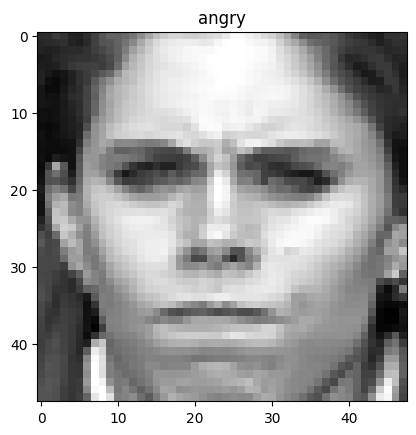

In [25]:
# predicts the label for an image
def compute_label(label_array, class_indexes):
    predicted_class_index = np.argmax(label_array)
    predicted_class = list(class_indexes.keys())[predicted_class_index]
    return predicted_class

plt.imshow(first_batch_images[5])
plt.title(compute_label(first_batch_labels[5], class_labels))

Text(0.5, 1.0, 'neutral')

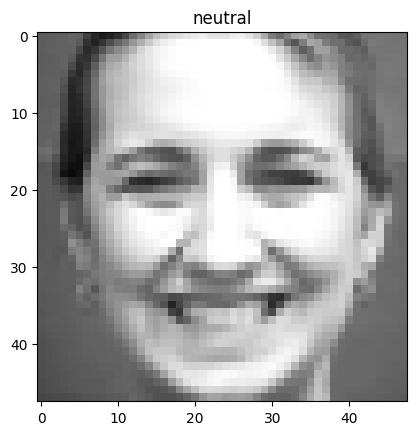

In [27]:
plt.imshow(first_batch_images[6])
plt.title(compute_label(first_batch_labels[6], class_labels))

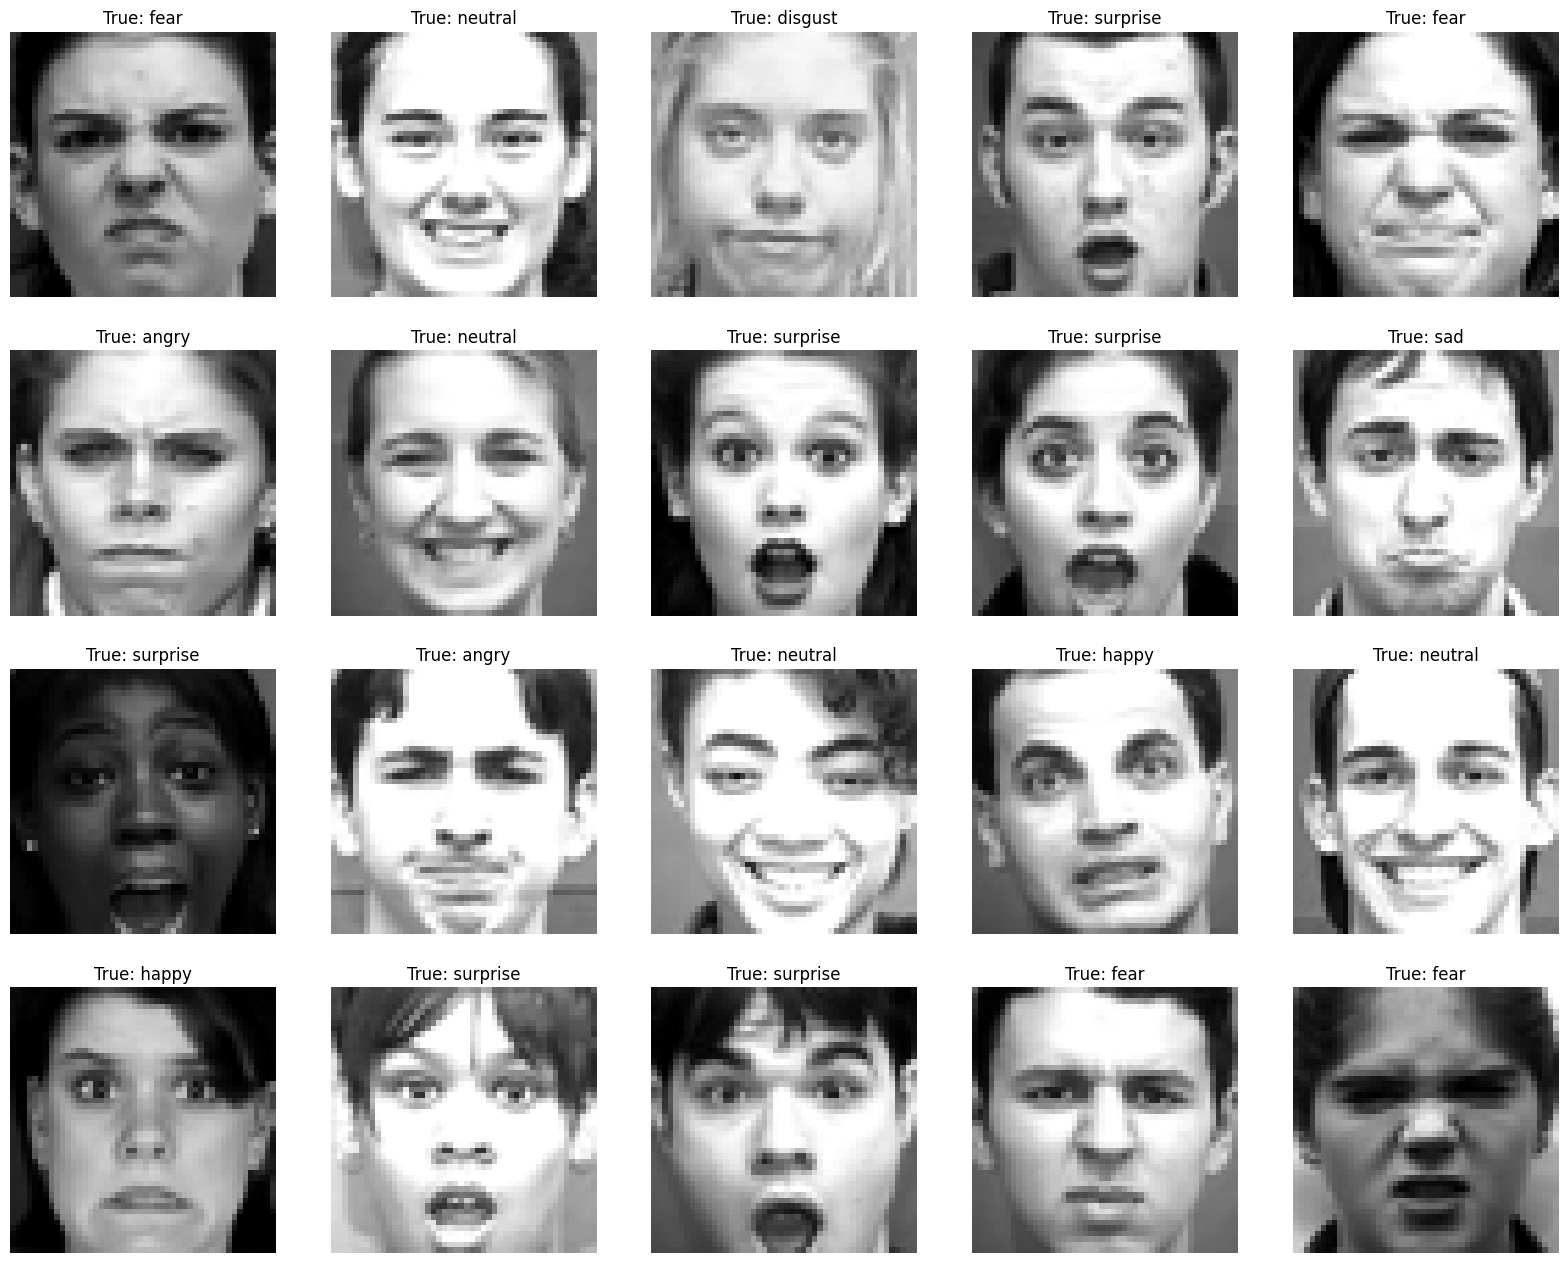

In [29]:
# Plotting the input data
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    title = f"True: {true_label}"
    plt.title(title)

##### There seems to be some misclassifications in the ck+ dataset

##### Lets try to use the model we trained on fer2013 dataset to predict images from ck+ dataset to check the model performance and ability to generalize on unseen data

1/1 [==============================] - 0s 82ms/step


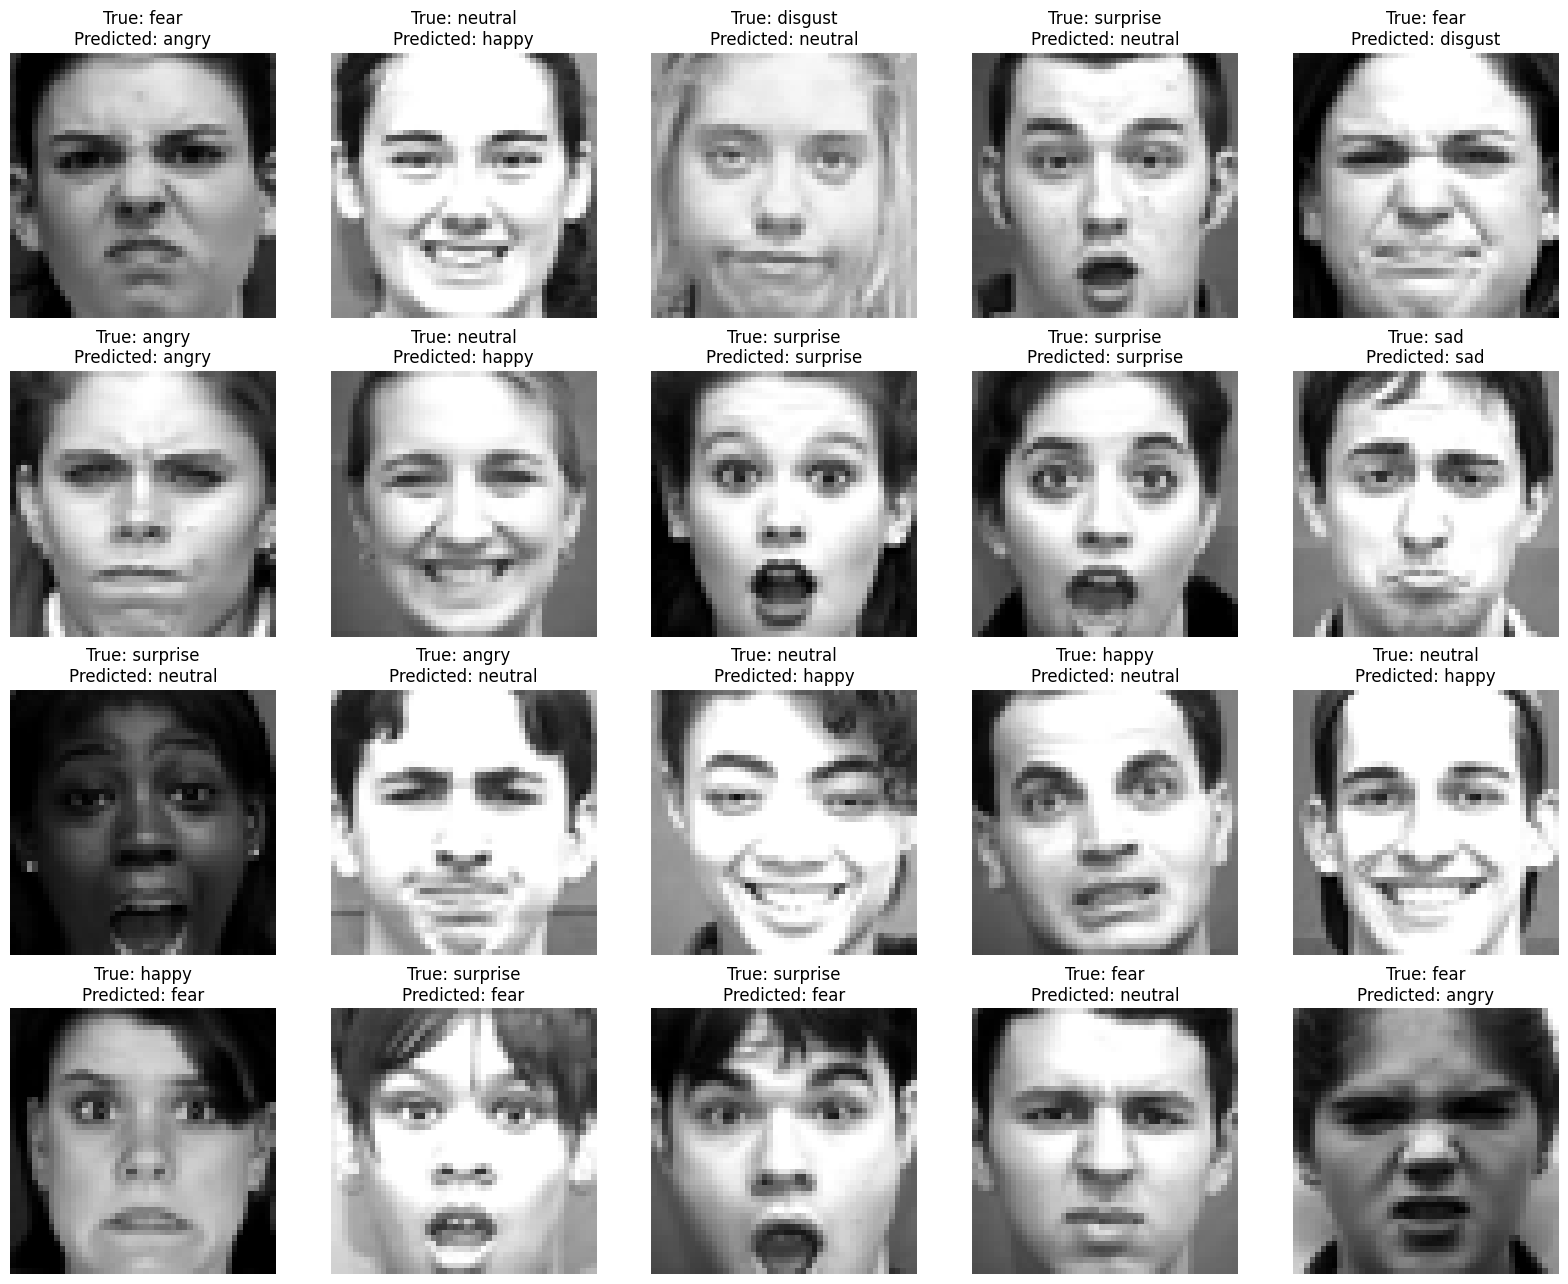

In [32]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

##### 1] In the above plot if we see the 1st image in 1st row the true label is fear but we can infer that it is "angry" emotion. Our model does a good job in predicting this emotion

##### 2] similarly for 2nd row 2nd image, 1st row 2nd image, 5th image in 1st row, 3rd row 3rd image, 3rd row last image, last row 1st image, last row 5th image. In all these scenarios our model is doing a very good job in predicting the correct emotion even though there is misclassification in the test dataset. Our model is generalizing better on unseen data.

1/1 [==============================] - 0s 58ms/step


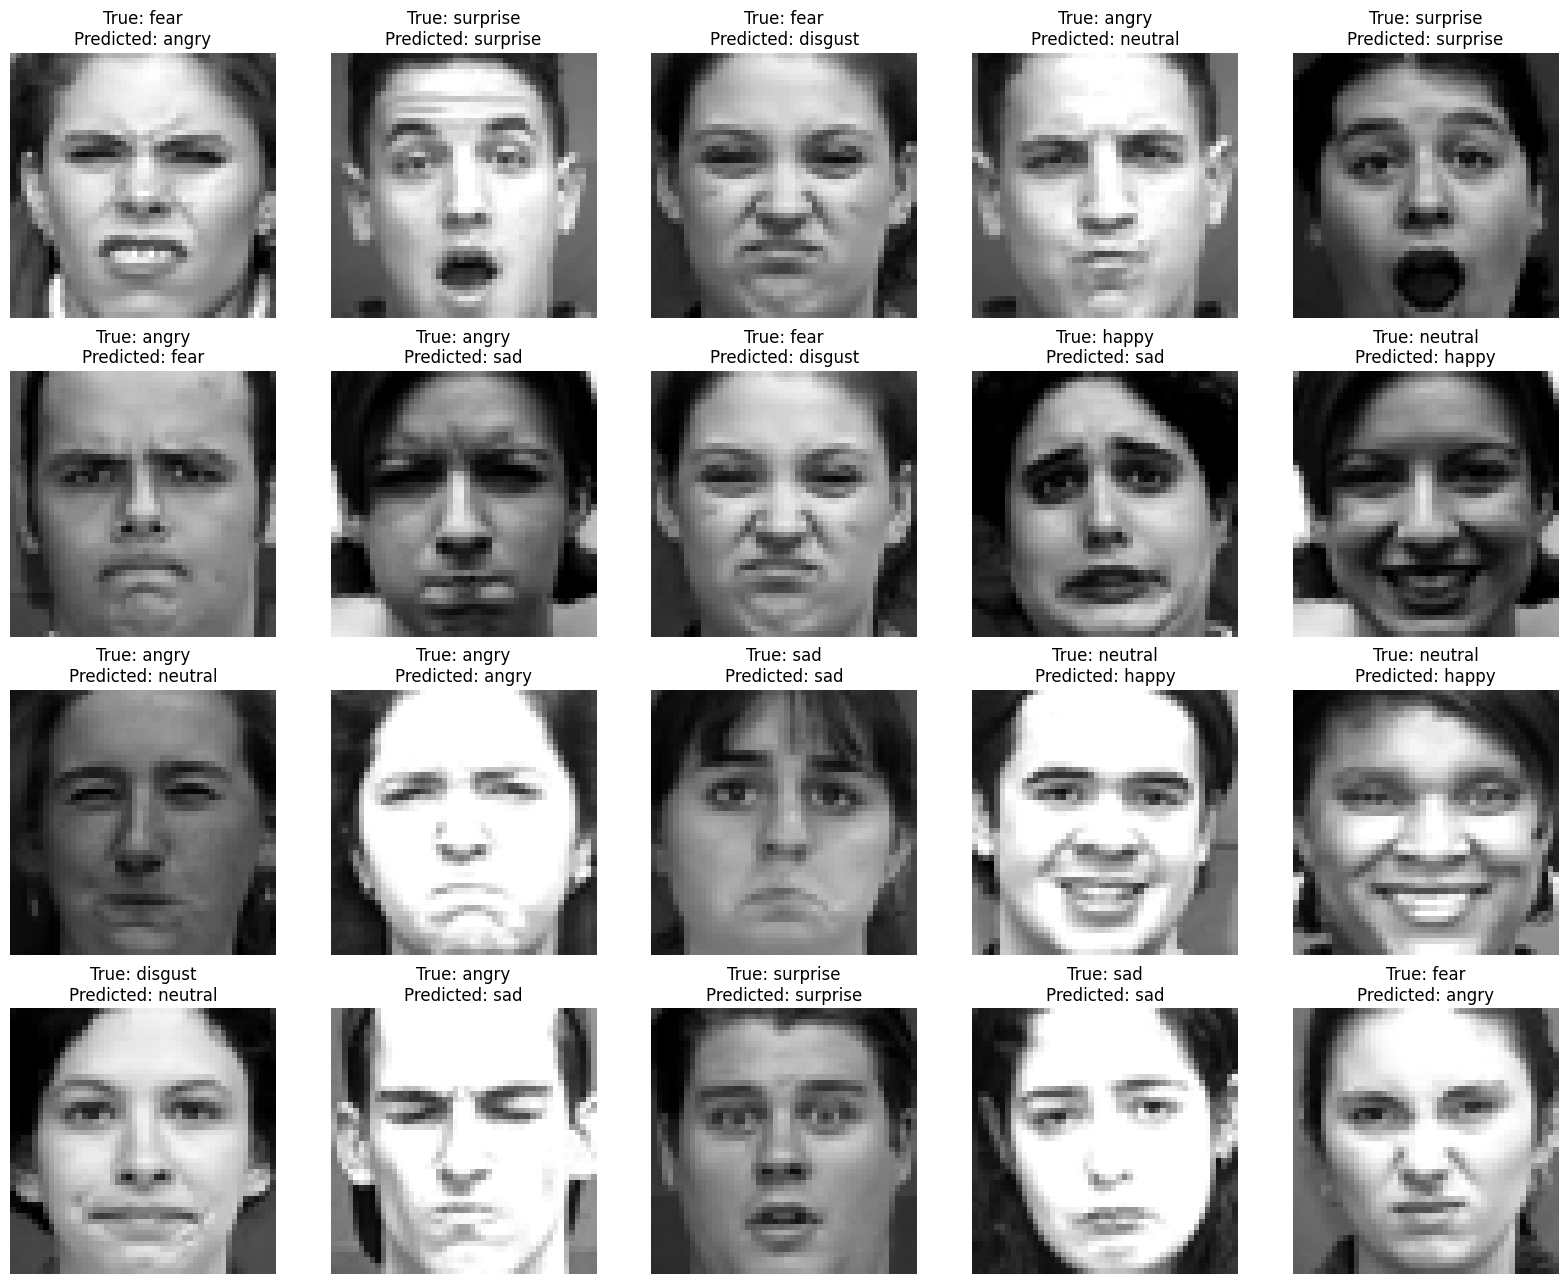

In [33]:
plt.figure(figsize=(20, 20))
j=1
for i in range(21, 41):
    plt.subplot(5,5,j)
    j = j+1
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)

1/1 [==============================] - 0s 38ms/step


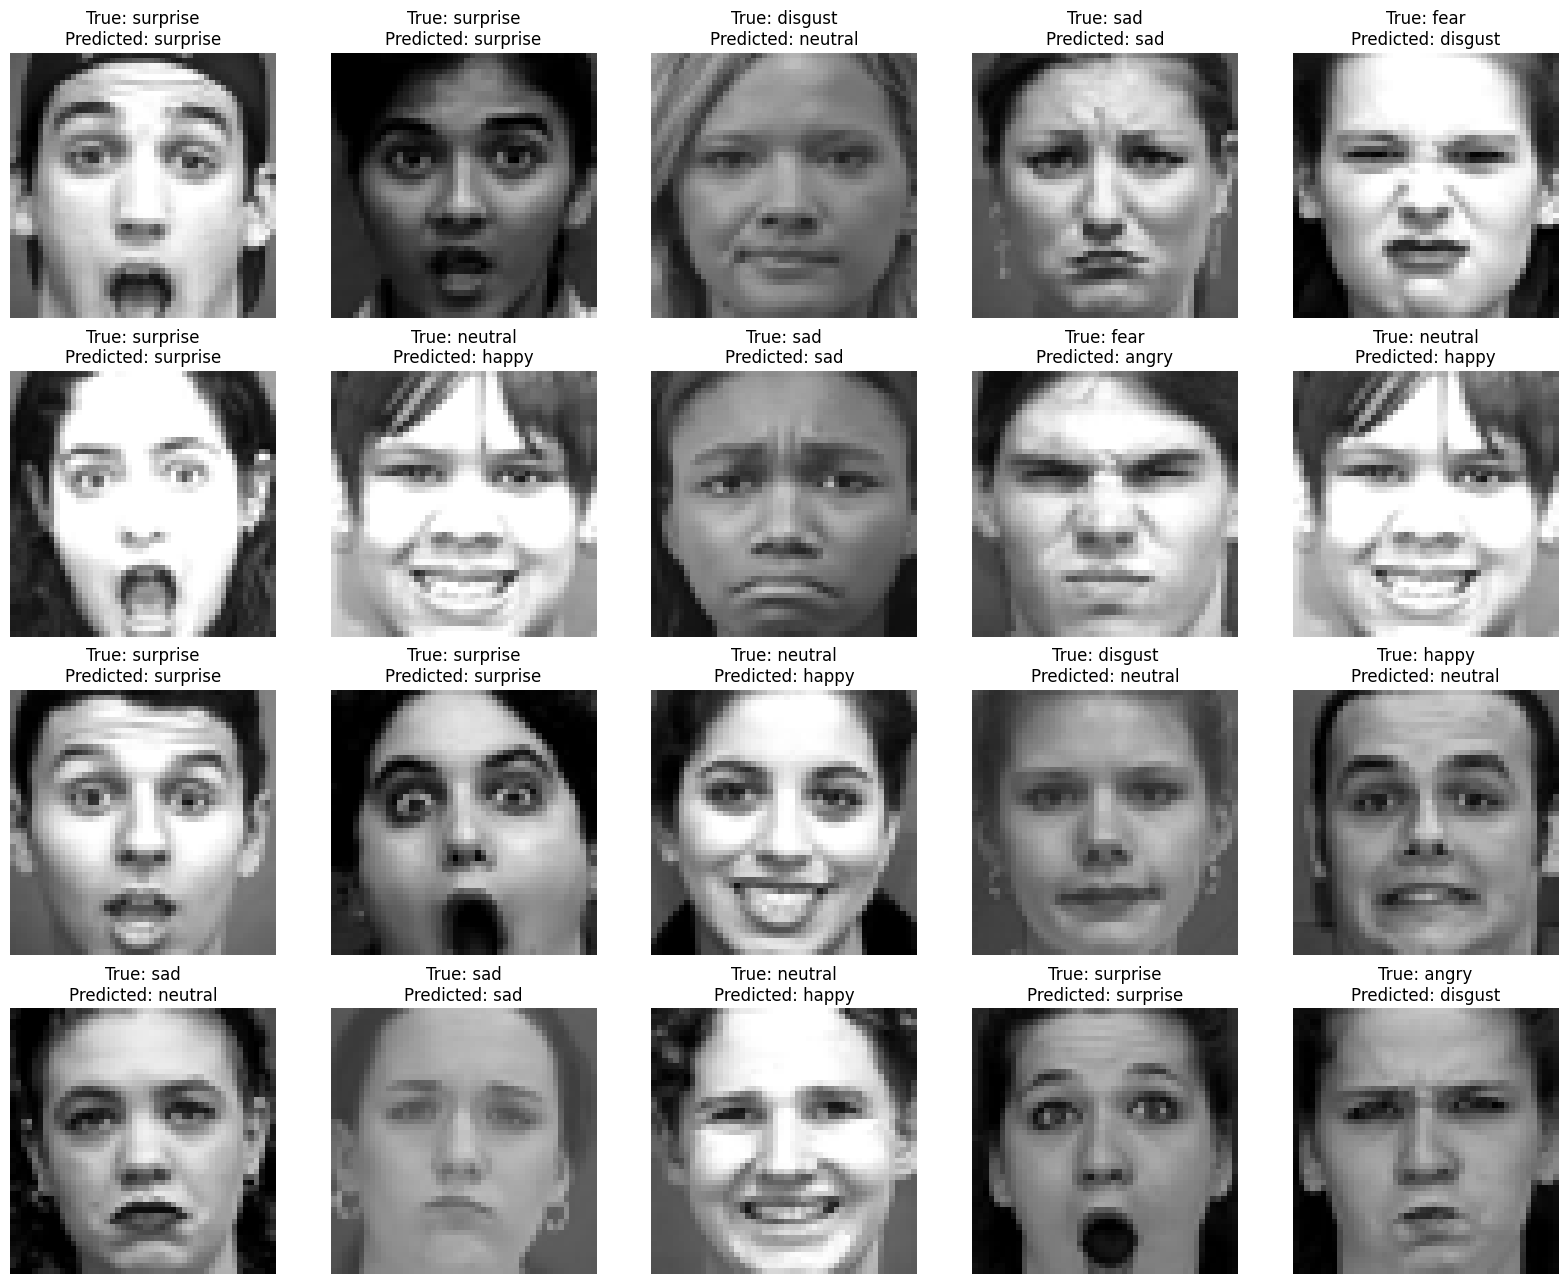

In [40]:
plt.figure(figsize=(20, 20))
j=1
for i in range(41, 61):
    plt.subplot(5,5,j)
    j = j+1
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.axis('off')
    true_label = compute_label(first_batch_labels[i], class_labels)
    predicted_label = compute_label(model.predict(first_batch_images[i].reshape((1, 48, 48, 3))), class_labels)
    title = f"True: {true_label}\nPredicted: {predicted_label}"
    plt.title(title)